# Classifying Population Dynamics

NOTE: This notebook is the same as the other one, but here we set p_death to 1.

In [1]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/nets.py
%run ../src/trainer.py
%run ../src/utils.py

Train a model based on Wright-Fisher simulations (without age structure).

In [2]:
classifier = TimeseriesClassifier(
    classifier=MultiLayerPerceptron(128, layers=(64, 64, 64)),
    embedder=ResNet(1)
)

In [3]:
tranformer = Compose(Normalizer(), Standardizer())
data = PresimulatedDataset.load("../data/20210430125743.npz")#, transform=Normalizer())

In [4]:
len(set(data.ids))

50000

In [6]:
data[6000]

(tensor([0.0273, 0.0379, 1.0000]),
 tensor([1106.0000,  231.4993,    6.8429,    1.9991,    1.5973,    1.4775,
            1.4209]))

Train the actual model. In each epoch, we simulate 50k samples with different parameters, $\theta$. The training procedure can probably be improved, but it already produces reasonable results.

In [7]:
classifier, train_loader, val_loader = train(
    data=data,
    classifier=classifier, 
    n_epochs=40, 
    batch_size=500, 
    device="cuda", 
    learning_rate=0.001,
    num_workers=40
)

Epoch  1: train loss = 0.28, val loss = 0.18, AUC = 0.97 ++
Epoch  2: train loss = 0.16, val loss = 0.16, AUC = 0.97 ++
Epoch  3: train loss = 0.15, val loss = 0.15, AUC = 0.98 ++
Epoch  4: train loss = 0.14, val loss = 0.15, AUC = 0.98 ++
Epoch  5: train loss = 0.14, val loss = 0.18, AUC = 0.97 --
Epoch  6: train loss = 0.15, val loss = 0.20, AUC = 0.97 --
Epoch  7: train loss = 0.14, val loss = 0.17, AUC = 0.98 --
Epoch  8: train loss = 0.14, val loss = 0.24, AUC = 0.97 --
Epoch  9: train loss = 0.13, val loss = 0.17, AUC = 0.98 --
Epoch 10: train loss = 0.13, val loss = 0.24, AUC = 0.97 --
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11: train loss = 0.14, val loss = 0.14, AUC = 0.98 ++
Epoch 12: train loss = 0.13, val loss = 0.14, AUC = 0.98 ++
Epoch 13: train loss = 0.13, val loss = 0.14, AUC = 0.98 --
Epoch 14: train loss = 0.13, val loss = 0.14, AUC = 0.98 --
Epoch 15: train loss = 0.13, val loss = 0.14, AUC = 0.98 --
Epoch 16: train loss = 0.13, val loss 

In [8]:
import multiprocessing as mp

classifier.eval()

def classify(theta, simulator, num_experiments=100, n_jobs=1):
    with mp.Pool(n_jobs) as pool:
        x = np.vstack(
            pool.starmap(simulator, [(theta, np.random.RandomState(i)) for i in range(num_experiments)])
        )
    with torch.no_grad():
        output = classifier(torch.FloatTensor(x).unsqueeze(1).to("cuda"))
    return output

In [9]:
import json

with open("../data/20210430125743.params.json") as f:
    params = json.load(f)
params

{'agents': 10000,
 'timesteps': 1000,
 'simulations': 50000,
 'workers': 50,
 'beta': [0.0, 0.1],
 'mu': [0.0001, 0.1],
 'p_death': [1.0, 1.0],
 'burn_in': 1000,
 'top_n': 0,
 'summarize': True}

In [10]:
neutral_simulator = Simulator(
    n_agents=params["agents"], 
    timesteps=params["timesteps"],
    age_window=None,
    disable_pbar=True,
    summarize=True
)

Test the performance of the model by classifying some generated samples. Given some $\theta_i$, we simulate 100 samples, and use the trained classifier to 'predict' whether they are examples of neutral evolution or not. The function returns the fraction of biased samples. 

First, let's test whether the model accurately classifies neutral samples to be neutral:

In [11]:
theta = torch.tensor([0., 0.01, 1.0])
output = classify(theta, neutral_simulator, n_jobs=25)
pred = (output < 0.5).float().mean().item()

print(f"p(y=0|x) = {pred:.3f}")

p(y=0|x) = 1.000


That seems to be working. And what about non-neutral, biased samples?

In [12]:
theta = torch.tensor([0.1, 0.01, 1.0])
output = classify(theta, neutral_simulator, n_jobs=25)
pred = (output > 0.5).float().mean().item()

print(f"p(y=1|x) = {pred:.3f}")

p(y=1|x) = 1.000


Also not bad. 

Next, we generate samples with the age-structured model and see whether the model (which was only trained on samples _without_ age structure) can still accurately discriminate between neutral an non-neutral samples:

In [13]:
age_structured_simulator = Simulator(
    n_agents=params["agents"], 
    timesteps=params["timesteps"],
    age_window=(0, 2),
    disable_pbar=True,
    summarize=True
)

In [14]:
theta = torch.tensor([0., 0.01, 1.0])
output = classify(theta, age_structured_simulator, n_jobs=25)
pred = (output < 0.5).float().mean().item()

print(f"p(y=0|x) = {pred:.3f}")

p(y=0|x) = 1.000


In [18]:
theta = torch.tensor([0.1, 0.01, 1.0])
output = classify(theta, age_structured_simulator, n_jobs=25)
pred = (output > 0.5).float().mean().item()

print(f"p(y=1|x) = {pred:.3f}")

p(y=1|x) = 1.000


In [19]:
import tqdm

betas = np.linspace(-0.1, 0.1, num=31)
p_deaths = np.linspace(0.01, 1.0, num=31)

neutral_scores, age_scores = [], []
with tqdm.tqdm(total=len(betas) * len(p_deaths)) as pbar:
    for beta in betas:
        for d in p_deaths:
            theta = torch.tensor([beta, 0.01, d])
            neutral_scores.append(classify(theta, neutral_simulator, n_jobs=25).cpu().numpy())
            age_scores.append(classify(theta, age_structured_simulator, n_jobs=25).cpu().numpy())
            pbar.update()

100%|██████████| 961/961 [7:16:47<00:00, 27.27s/it]  


In [20]:
neutral_results = np.array(neutral_scores).reshape(len(betas), len(p_deaths), -1)
age_results = np.array(age_scores).reshape(len(betas), len(p_deaths), -1)

The plot below visualizes the results:

In [21]:
neutral_matrix = np.zeros((len(betas), len(p_deaths)))

for i, beta in enumerate(betas):
    for j, p_death in enumerate(p_deaths):
        scores = neutral_results[i, j]
        if beta != 0:
            score = (scores > 0.5).mean()
        else:
            score = (scores < 0.5).mean()
        neutral_matrix[i, j] = score

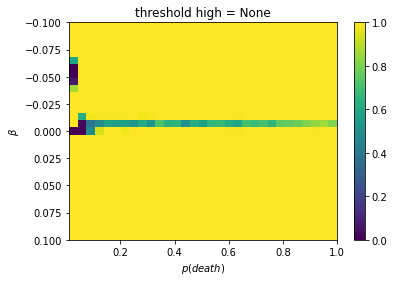

In [22]:
fig, ax = plt.subplots()

img = ax.imshow(
    neutral_matrix, 
    extent=[p_deaths.min(), p_deaths.max(), betas.max(), betas.min()],
    aspect="auto"
)
ax.set(xlabel="$p(death)$", ylabel="$\\beta$", title="threshold high = None")
plt.colorbar(img);

In [23]:
age_matrix = np.zeros((len(betas), len(p_deaths)))

for i, beta in enumerate(betas):
    for j, p_death in enumerate(p_deaths):
        scores = age_results[i, j]
        if beta != 0:
            score = (scores > 0.5).mean()
        else:
            score = (scores < 0.5).mean()
        age_matrix[i, j] = score

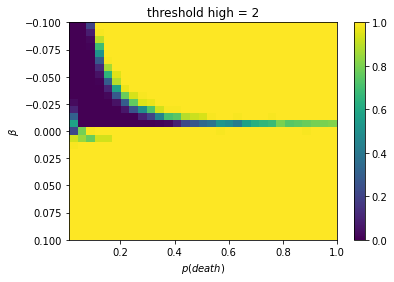

In [24]:
fig, ax = plt.subplots()

img = ax.imshow(
    age_matrix, 
    extent=[p_deaths.min(), p_deaths.max(), betas.max(), betas.min()],
    aspect="auto"
)
ax.set(xlabel="$p(death)$", ylabel="$\\beta$", title="threshold high = 2")
plt.colorbar(img);